In [1]:
from brainiak.isc import isc,bootstrap_isc,compute_summary_statistic
import pandas as pd
import numpy as np
import nibabel as nib
from nilearn.image import index_img,concat_imgs,resample_to_img,smooth_img,math_img
from nilearn.masking import apply_mask,unmask
from nilearn import plotting as niplt
import os
import time
from scipy.stats import mode as statmode
import matplotlib.pyplot as plt
import pickle
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from skimage.measure import label as dolabel
from skimage.measure import regionprops
from scipy.stats import ttest_1samp,ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from scipy.stats import f_oneway
from statsmodels.stats.anova import AnovaRM

# Export results

def export_results(iscstat,c,t,fld_out,logsumm):


    unthres = unmask(iscstat[c]['m'],av_mask_img)

    if t == 'No':
        thres_m = unmask(iscstat[c]['m'] * (iscstat[c]['p']< p_thres[t]),av_mask_img)
    elif t == 'FDR':
        isc_pmask,isc_pcorr = fdrcorrection(iscstat[c]['p'], p_thres[t])
        thres_m = unmask(iscstat[c]['m'] * isc_pmask, av_mask_img)

    thres_mc, cl = filter_clusters(thres_m,c_thres[t])
    thres_mc_bin = math_img('im > 0',im=thres_mc)


    ## Save Maps
    # Untresholded
    fout = fld_out + '{}_isc_{}.nii.gz'.format(isc_type,c,t)
    nib.save(unthres, fout)
    # Thresholded
    fout = fld_out + '{}_isc_{}_{}{}_k{:02d}.nii.gz'.format(isc_type,c,t,str(p_thres[t])[2:],c_thres[t])
    nib.save(thres_mc, fout)
    # Thresholded binary
    fout = fld_out + '{}_isc_{}_{}{}_k{:02d}_bin.nii.gz'.format(isc_type,c,t,str(p_thres[t])[2:],c_thres[t])
    nib.save(thres_mc_bin, fout)

    # Figure
    fig,ax = plt.subplots(figsize = (9,3))
    niplt.plot_glass_brain(thres_mc, figure=fig,axes=ax,colorbar = True)
    ax.set_title(r'{} ISC - {} correction ($\alpha = {}$, $\kappa = {}$)'.format(isc_type,t,p_thres[t],c_thres[t]))

    fout = fld_out + '{}_isc_{}_{}{}_k{:02d}.pdf'.format(isc_type,c,t,str(p_thres[t])[2:],c_thres[t])

    plt.savefig(fout)
    plt.close('all')


    # Some logs
    included_subjects = logsumm.sort_values('subject')['subject'].unique()
    np.savetxt(fld_out + 'included_subjects.txt', included_subjects)

    included_movies = logsumm.sort_values('Title')['Title'].unique()
    np.savetxt(fld_out + 'included_movies.txt', included_movies, fmt = '%s')

    return thres_mc


def filter_clusters(thresholded_image,cluster_threshold):

    imgdata = np.nan_to_num(thresholded_image.get_fdata(),0)
    labeled = dolabel(imgdata != 0, background=0, connectivity = 2)
    labprops = regionprops(labeled)

    clusters = []
    for c in labprops:
        if c.area < cluster_threshold:
            labeled[labeled == c.label] = 0
        else:
            clusters.append([c.label,c.area])
        
    clusters = np.array(clusters)
    
    filtered_data = imgdata*(labeled > 0)
    filtered_image = nib.Nifti1Image(filtered_data,header=thresholded_image.header,affine=thresholded_image.affine)
    
    return filtered_image,clusters

def do_RM_Ftest(iscdata):
    
    n_sub,n_vox = np.shape(iscdata['M'])

    F = np.zeros(n_vox)
    pF = np.zeros_like(F)

    for nv in range(n_vox):
        df = pd.DataFrame()
        for c in iscdata:
            vox_data = iscdata[c][:,nv]

            this_df = (pd
               .DataFrame(np.array([np.arange(n_sub),vox_data]).T,columns=['sub_id','z'])
               .assign(cond = c)
               .assign(sub_id = lambda d : d['sub_id'].astype(int))
              )

            df  = df.append(this_df)

        aovrm = AnovaRM(df,'z', 'sub_id', within=['cond'])
        res = aovrm.fit()

        F[nv] = res.anova_table['F Value']
        pF[nv] = res.anova_table['Pr > F']

        print('{:07d} out of {:07d} done...'.format(nv,n_vox), end='\r', flush=True)
            
    return F,pF

In [2]:
froot = '/data00/layerfMRI/'
isc_fld = froot + 'analyses/ISC/'
av_mask_img = isc_fld + 'masks/average_mask_mni.nii.gz'
Nvox = int(np.sum(apply_mask(av_mask_img,av_mask_img)))

In [3]:
logsumm = (pd
           .read_csv(froot+ 'logs/log_summary.csv')
           .assign(fmri = lambda d:
                   froot + 
                   'regdata/sub_' + d['subject'].apply(lambda n: '{:02d}'.format(n)) +
                   '/ses_' + d['session'].apply(lambda n: '{:02d}'.format(n)) +
                   '/func/task_' + d['task'].apply(lambda n: '{:01d}'.format(n)) +
                   '_run_' + d['run'].apply(lambda n: '{:01d}'.format(n)) +
                   '_4D_MNI.nii.gz'
                  )
           .assign(fmri_missing = lambda d : d['fmri'].apply(lambda s: os.path.isfile(s) != True))
           
          )

Nsub = logsumm['subject'].nunique()

In [4]:
#### IGNORE SUBJECT 8
logsumm = logsumm.loc[lambda d : d['subject'] != 8]

movies = {}
for m,df in logsumm.groupby('Type'):
    movies[m] = list(df['Title'].unique())

In [5]:
logsumm.sort_values('subject')['subject'].unique()

array([ 2,  3,  5,  6,  9, 10, 11, 12, 14])

In [6]:
data = {}
data_mov = {}
data_mov_run = {}

c = 'M'

for c in ['M','S']:
    data_mov[c] = {}
    data_mov_run[c] = {}


    for im,movfile in enumerate(movies[c]):

        mov = movfile.split('.')[0]
        data_mov_run[c][mov] = {}

        for run,rdf in logsumm.loc[lambda d : d['Title'] == movfile].groupby('run'):

            fpickle = isc_fld + f'isc_preloaded_input_6mm/{c}_{mov}_run{run}.pickle'
            if os.path.isfile(fpickle):
                with open(fpickle, 'rb') as fid:
                    data_mov_run[c][mov][run] = pickle.load(fid)  
                print('{} loaded successfully'.format(fpickle))

            else:

                print('{} skipped <--------------'.format(fpickle))
        try:
            # After looping through the runs I can concatenate them into an array
            data_mov[c][mov] = np.concatenate([data_mov_run[c][mov][run] for run in data_mov_run[c][mov]], axis = 0)
            print('Movie {} completed [{:02d}/{:02d}]'.format(mov,im+1,len(movies[c])))
        except:
            print('Movie {} missing [{:02d}/{:02d}]'.format(mov,im+1,len(movies[c])))

    data[c] = np.concatenate([data_mov[c][mov] for mov in data_mov[c]], axis = 0)

/data00/layerfMRI/analyses/ISC/isc_preloaded_input_6mm/M_M1ballonD_run1.pickle loaded successfully
/data00/layerfMRI/analyses/ISC/isc_preloaded_input_6mm/M_M1ballonD_run2.pickle loaded successfully
Movie M1ballonD completed [01/18]
/data00/layerfMRI/analyses/ISC/isc_preloaded_input_6mm/M_M3breakfastD_run1.pickle loaded successfully
/data00/layerfMRI/analyses/ISC/isc_preloaded_input_6mm/M_M3breakfastD_run2.pickle loaded successfully
Movie M3breakfastD completed [02/18]
/data00/layerfMRI/analyses/ISC/isc_preloaded_input_6mm/M_M6cigaretteD_run1.pickle loaded successfully
/data00/layerfMRI/analyses/ISC/isc_preloaded_input_6mm/M_M6cigaretteD_run2.pickle loaded successfully
Movie M6cigaretteD completed [03/18]
/data00/layerfMRI/analyses/ISC/isc_preloaded_input_6mm/M_M7flowersD_run1.pickle loaded successfully
/data00/layerfMRI/analyses/ISC/isc_preloaded_input_6mm/M_M7flowersD_run2.pickle loaded successfully
Movie M7flowersD completed [04/18]
/data00/layerfMRI/analyses/ISC/isc_preloaded_input_

In [7]:
# One Sample

In [8]:
isc_type = 'loo' ## 'loo' or 'pair'
dopair = (isc_type == 'pair')

In [9]:
fld_out = isc_fld + '{}_isc_6mm/'.format(isc_type)
if not os.path.isdir(fld_out):
    os.makedirs(fld_out)

In [10]:
iscdata = {}
iscstat = {}

for c in ['M','S']:
    iscstat[c] = {}

    iscdata[c] = isc(data[c], pairwise=dopair)
    iscdata[c][np.isnan(iscdata[c])] = 0

/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/brainiak/utils/utils.py:994: RuntimeWarning: invalid value encountered in true_divide
  return numerator / denominator


In [11]:
# One sample
for c in ['M','S']:
    iscstat[c]['m'],iscstat[c]['ci'],iscstat[c]['p'],iscstat[c]['d'] = bootstrap_isc(iscdata[c], n_bootstraps=5000, pairwise=dopair,summary_statistic='median')

In [12]:
# F test (Repeated Measure)
c = 'F_M-S'
iscstat[c] = {}
n_sub,n_vox = np.shape(iscdata['M'])

iscstat[c]['m'], iscstat[c]['p'] = do_RM_Ftest(iscdata)

In [13]:
p_thres = {'No':0.001,'FDR':0.05}
c_thres = {'No':50,'FDR':20}

In [14]:
thres_map = {}
for c in iscstat:
    thres_map[c] = {}
    for t in p_thres:
        thres_map[c][t] = export_results(iscstat,c,t,fld_out,logsumm)

sizeof_hdr should be 348; set sizeof_hdr to 348
sizeof_hdr should be 348; set sizeof_hdr to 348
sizeof_hdr should be 348; set sizeof_hdr to 348
sizeof_hdr should be 348; set sizeof_hdr to 348
sizeof_hdr should be 348; set sizeof_hdr to 348
/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))
sizeof_hdr should be 348; set sizeof_hdr to 348


In [15]:
# Save OR map

for t in p_thres:

    M_OR_S = math_img('(im1 + im2) > 0',im1 = thres_map['M'][t], im2 = thres_map['S'][t])
    
    # Thresholded binary
    fout = fld_out + '{}_isc_{}_{}{}_k{:02d}_bin.nii.gz'.format(isc_type,'M_OR_S',t,str(p_thres[t])[2:],c_thres[t])
    nib.save(M_OR_S, fout)

    # Figure
    fig,ax = plt.subplots(figsize = (9,3))
    niplt.plot_glass_brain(M_OR_S, figure=fig,axes=ax,colorbar = True)
    ax.set_title(r'{} ISC - {} correction ($\alpha = {}$, $\kappa = {}$)'.format(isc_type,t,p_thres[t],c_thres[t]))

    fout = fld_out + '{}_isc_{}_{}{}_k{:02d}.pdf'.format(isc_type,'M_OR_S',t,str(p_thres[t])[2:],c_thres[t])

    plt.savefig(fout)
    plt.close('all')

In [ ]:
F,pF = do_RM_Ftest(iscdata)

In [44]:
# aovrm = AnovaRM(df,'z', 'sub', within=['vox'])
# res = aovrm.fit()

In [45]:
# F,P = f_oneway(np.arctanh(iscdata['M']),np.arctanh(iscdata['S']))

In [46]:
t = 'No'
if t == 'No':
    thres_m = unmask(F * (pF < p_thres[t]),av_mask_img)
elif t == 'FDR':
    isc_pmask,isc_pcorr = fdrcorrection(pF, p_thres[t])
    thres_m = unmask(F * isc_pmask, av_mask_img)

thres_mc, cl = filter_clusters(thres_m,c_thres[t])
thres_mc_bin = math_img('im > 0',im=thres_mc)

sizeof_hdr should be 348; set sizeof_hdr to 348


/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/nilearn/plotting/displays.py:780: UserWarning: empty mask
  get_mask_bounds(new_img_like(img, not_mask, affine))


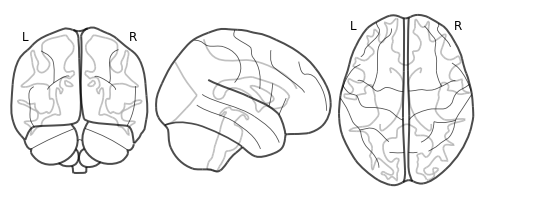

In [47]:
niplt.plot_glass_brain(thres_mc_bin, colorbar=True)

In [26]:
thres_mc = {}
t = 'No'
for c in ['M','S']:
    if t == 'No':
        thres_m = unmask(iscstat[c]['m'] * (iscstat[c]['p']< p_thres[t]),av_mask_img)
    elif t == 'FDR':
        isc_pmask,isc_pcorr = fdrcorrection(iscstat[c]['p'], p_thres[t])
        thres_m = unmask(iscstat[c]['m'] * isc_pmask, av_mask_img)

    thres_mc[c], cl = filter_clusters(thres_m,c_thres[t])
    
thres_mc_OR = math_img('(im1 + im2) > 0',im1 = thres_mc['M'], im2 = thres_mc['S'])

sizeof_hdr should be 348; set sizeof_hdr to 348
sizeof_hdr should be 348; set sizeof_hdr to 348


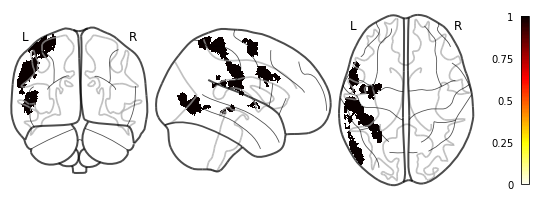

In [27]:
niplt.plot_glass_brain(thres_mc_OR, colorbar=True)

In [29]:
html_view = niplt.view_img(thres_mc_OR, colorbar=True)

/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


In [30]:
fld_out

'/data00/layerfMRI/analyses/ISC/loo_isc_6mm/'

In [31]:
html_view.save_as_html(fld_out + 'OR.html')

In [201]:
# fig,axarr = plt.subplots(nrows = 2, figsize = (16,4))

# a = niplt.plot_stat_map(tres_mc, display_mode = 'x', cut_coords=np.arange(-60,-44,2), axes = axarr[0])
# niplt.plot_stat_map(tres_mc, display_mode = 'z', cut_coords=np.arange(30,46,2), axes = axarr[1])

# fig.suptitle('{}ISC - condition {} - 1000 Bootstrap - p = 0.005 - k = 50'.format(pairstr[dopair],c))

# # plt.savefig(froot + 'iscdata/figs/{}ISC_{}.pdf'.format(pairstr[dopair],c), dpi = 600)

## Different approach (do not concatenate)

In [19]:
sub_av_isc = {}

for c in ['M','S']:

    all_isc = []
    for mov in data_mov_run[c]:
        for run in data_mov_run[c][mov]:
            single_isc = isc(data_mov_run[c][mov][run],pairwise=dopair)
            single_isc[np.isnan(single_isc)] = 0
            all_isc.append(single_isc)
            
    all_isc = np.array(all_isc)
    
    sub_av_isc[c] = np.average(all_isc,axis = 1)
    

In [20]:
c = 'S'

In [21]:
# isc_m,isc_p = ttest_ind(np.arctanh(sub_av_isc['M']),np.arctanh(sub_av_isc['S']),axis=0)
# isc_pmask,isc_pcorr = fdrcorrection(isc_p,0.05)

In [22]:
isc_m,isc_p = ttest_1samp(np.arctanh(sub_av_isc[c]),0,axis=0)
isc_pmask,isc_pcorr = fdrcorrection(isc_p,0.05)

In [31]:
tres_m = unmask(isc_m * (isc_p < 0.002),av_mask_img)
tres_mc, cl = filter_clusters(tres_m,20)

/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.
sizeof_hdr should be 348; set sizeof_hdr to 348


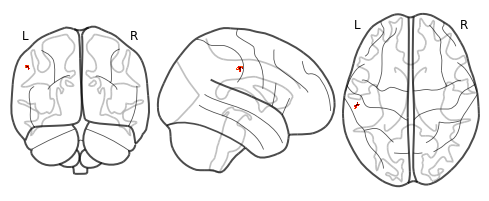

In [32]:
niplt.plot_glass_brain(tres_mc)

In [151]:
from scipy.stats import ttest_1samp, ttest_ind
from statsmodels.stats.multitest import fdrcorrection

In [ ]:
iscstat[c]['m'],iscstat[c]['p'] = ttest_1samp(np.arctanh(iscdata[c]),0,axis=0)
iscstat[c]['pmask'],iscstat[c]['pcorr'] = fdrcorrection(iscstat[c]['p'],0.05)

In [ ]:
tres_m = unmask(iscstat[c]['m'] * (iscstat[c]['p'] < 0.005),av_mask_img)
tres_mc, cl = filter_clusters(tres_m,50)

In [ ]:
fig,axarr = plt.subplots(nrows = 2, figsize = (16,4))

a = niplt.plot_stat_map(tres_mc, display_mode = 'x', cut_coords=np.arange(-60,-44,2), axes = axarr[0])
niplt.plot_stat_map(tres_mc, display_mode = 'z', cut_coords=np.arange(30,46,2), axes = axarr[1])

fig.suptitle('ttestISC - condition {} - 1000 Bootstrap - p = 0.005 - k = 50'.format(c))

plt.savefig(froot + 'iscdata/figs/ttestISC_{}.pdf'.format(c), dpi = 600)

In [ ]:
mimg = unmask(iscstat[c]['m'] * (iscstat[c]['p']<0.001),av_mask_img)


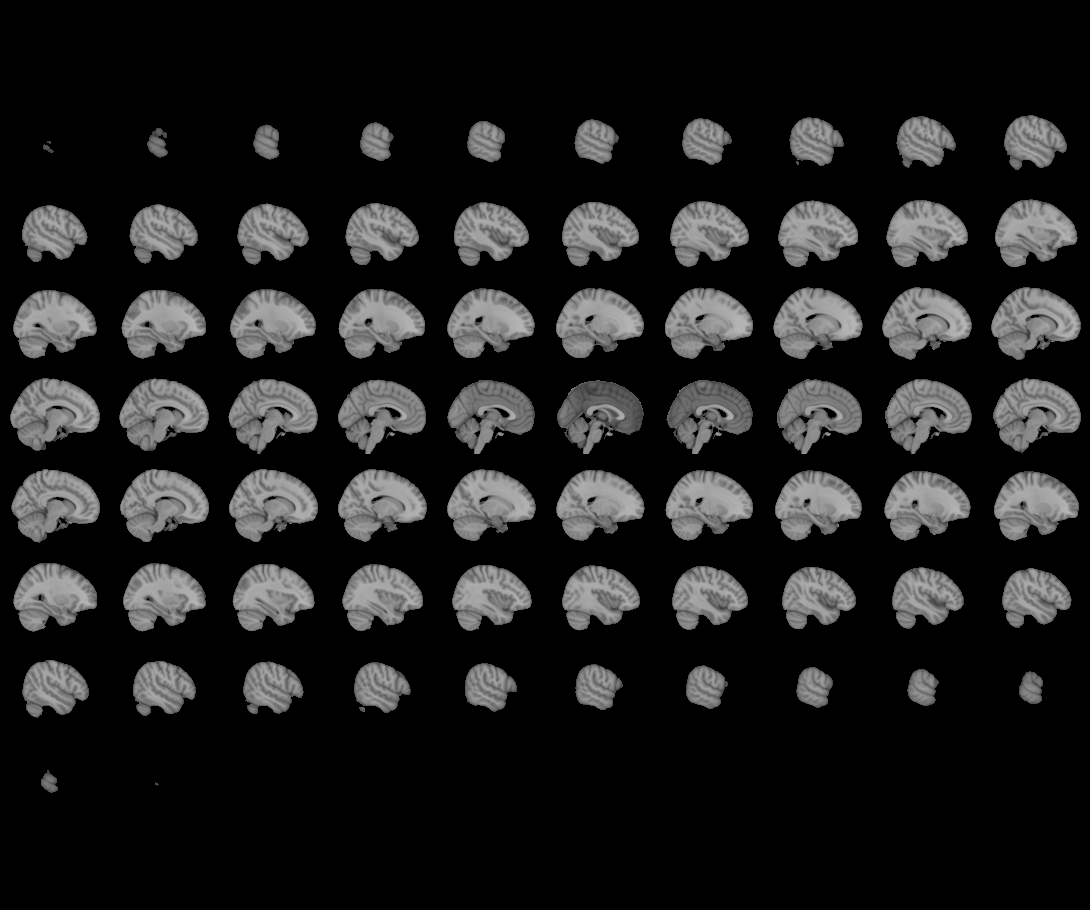
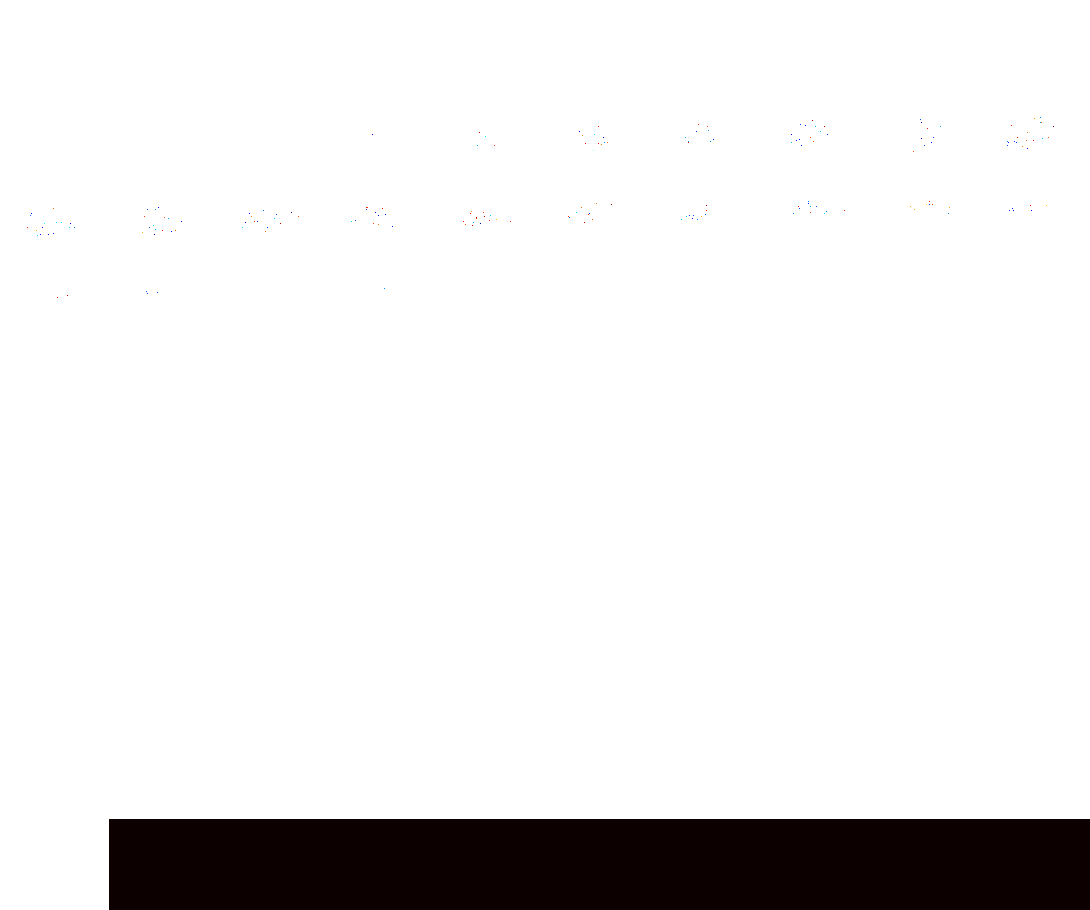

In [120]:
niplt.view_img(mimg)

(12, 79881)

In [19]:
### Make mask
masks = []
for f in logsumm['fmri'].values:

    m = nib.load(f.replace('_4D_MNI','_mean_brain_mask'))
    masks.append(m.get_fdata())
masks = np.array(masks)
av_mask = np.average(masks, axis = 0)

In [20]:
av_mask_img = nib.Nifti2Image(av_mask > 0, header = m.header, affine=m.affine)

sizeof_hdr should be 540; set sizeof_hdr to 540


In [21]:
nib.save(av_mask_img,froot + 'masks/average_mask_befpre.nii.gz')

In [22]:
av_mask_img_mni = resample_to_img(av_mask_img,logsumm['fmri'].iloc[0])

In [23]:
nib.save(av_mask_img_mni,froot + 'masks/average_mask_mni_befpre.nii.gz')

/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/nilearn/image/resampling.py:513: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))
/home/deangelis/anaconda3/envs/brainiak/lib/python3.7/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



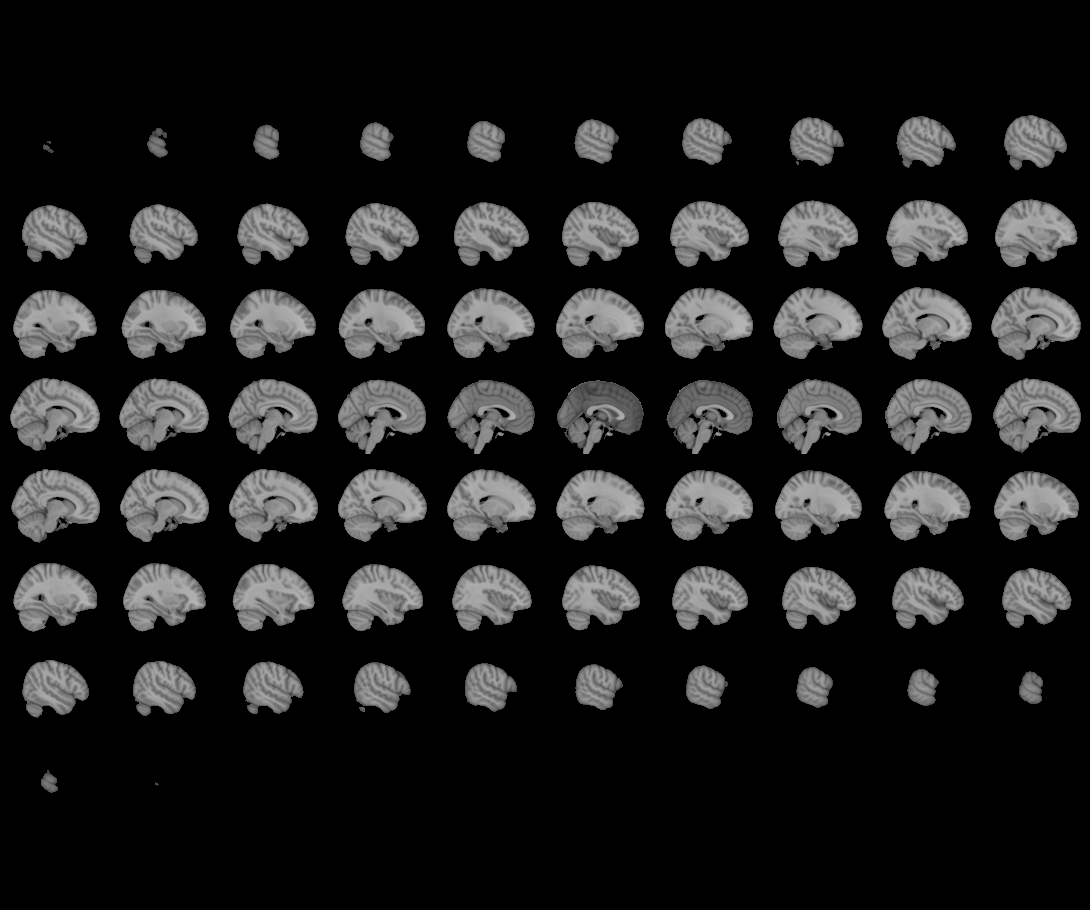
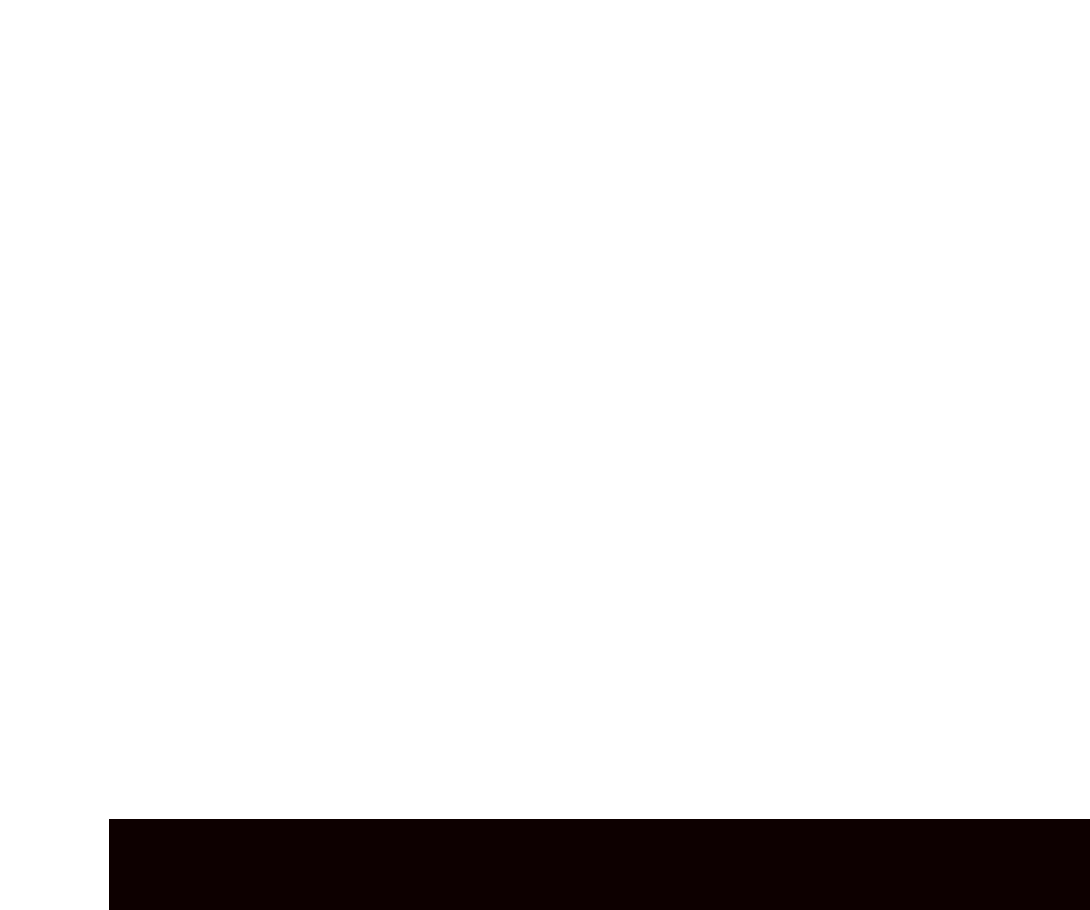

In [288]:
niplt.view_img(av_mask_img_mni)